In [1]:
import pandas as pd
import matplotlib as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
AEP = pd.read_csv("/content/drive/MyDrive/AEP_hourly.csv")

AEP.head(3)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0


In [4]:
AEP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [5]:
AEP['Datetime'] = pd.to_datetime(AEP['Datetime'])
AEP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Datetime  121273 non-null  datetime64[ns]
 1   AEP_MW    121273 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.9 MB


In [6]:
AEP.set_index('Datetime', inplace=True)
AEP.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [ ]:
# Jumlahkan per hari (D = daily)
AEPdaily = AEP.resample('D').sum()

# Cek hasilnya
print(AEPdaily.tail())


In [8]:
AEPdaily = AEPdaily.iloc[:-1]
print(AEPdaily.tail())

              AEP_MW
Datetime            
2018-07-29  327792.0
2018-07-30  368834.0
2018-07-31  364327.0
2018-08-01  363628.0
2018-08-02  376504.0


<Axes: xlabel='Datetime'>

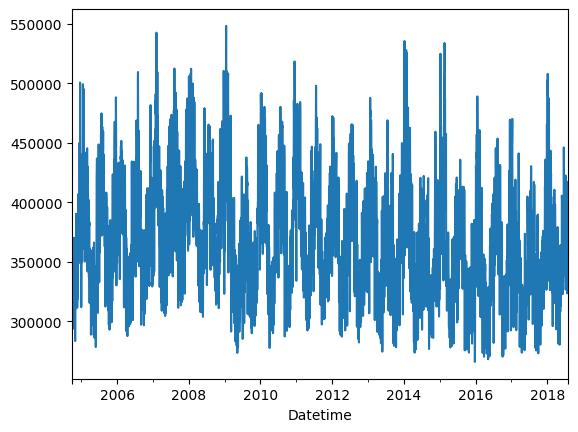

In [9]:
AEPdaily['AEP_MW'].plot()

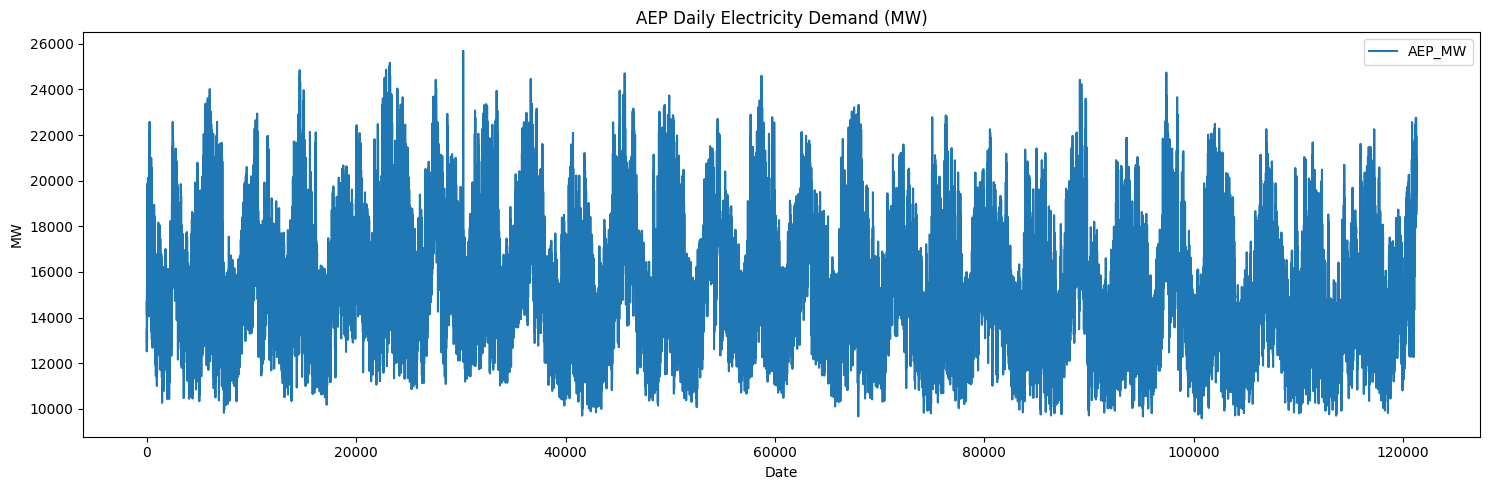

In [136]:
import matplotlib.pyplot as plt

AEP.plot(figsize=(15, 5), title='AEP Daily Electricity Demand (MW)')
plt.ylabel('MW')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

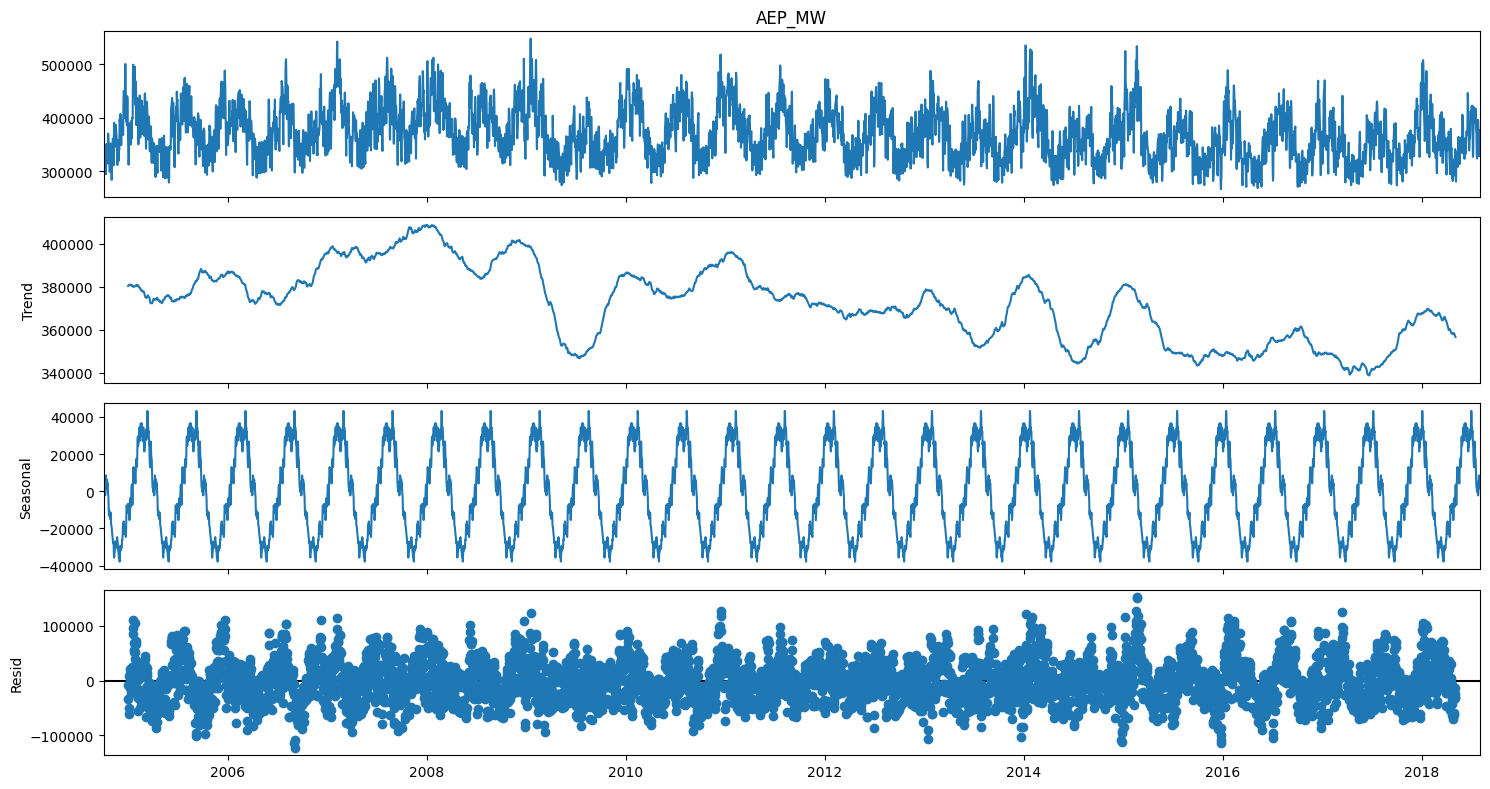

In [145]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(AEPdaily['AEP_MW'],model='additive', period=180)
fig = decompose.plot()
fig.set_size_inches(15, 8)
plt.tight_layout()
plt.show()

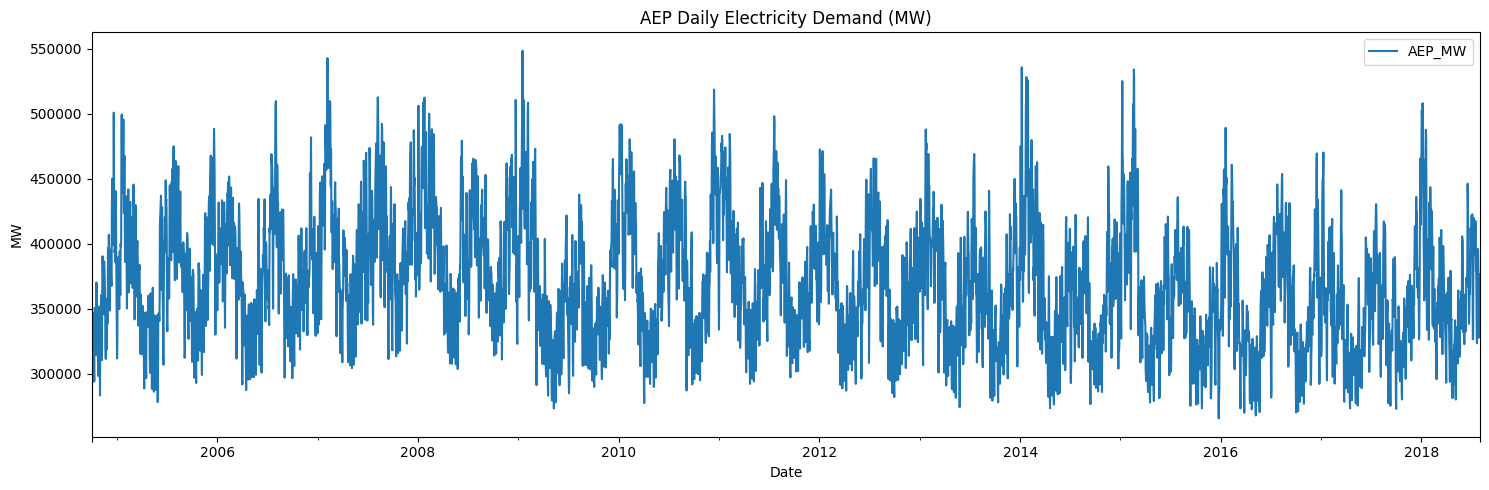

In [11]:
import matplotlib.pyplot as plt

AEPdaily.plot(figsize=(15, 5), title='AEP Daily Electricity Demand (MW)')
plt.ylabel('MW')
plt.xlabel('Date')
plt.tight_layout()
plt.show()


Train shape: (3379, 1)
Test shape: (1675, 1)


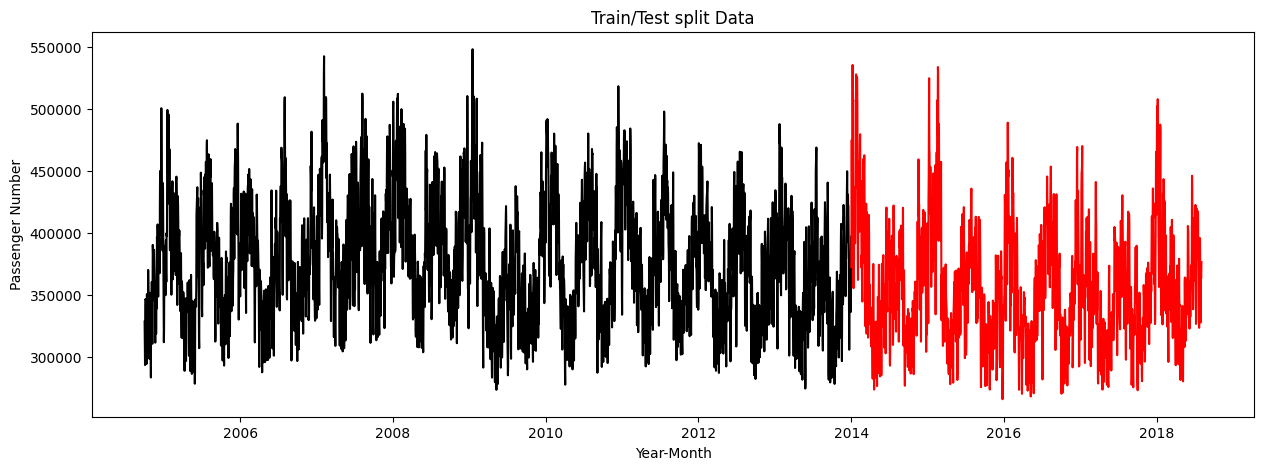

In [148]:
import matplotlib.pyplot as plt

train = AEPdaily[AEPdaily.index < '2014-01-01']
test = AEPdaily[AEPdaily.index >= '2014-01-01']

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
plt.figure(figsize=(15, 5))
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split Data")
plt.ylabel("Passenger Number")
plt.xlabel('Year-Month')

plt.show()


In [24]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -6.40073154678464
p-value: 1.9985741115268156e-08


In [25]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

In [26]:
forecast = model_fit.forecast(steps=len(test))

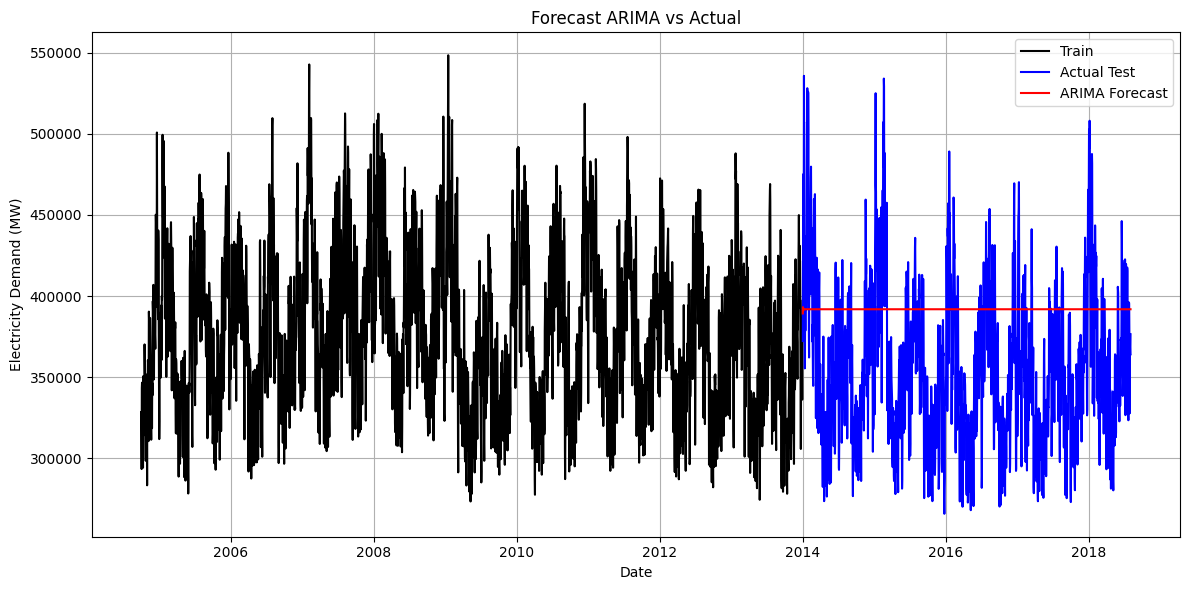

In [149]:
import matplotlib.pyplot as plt

# Forecast sepanjang panjang data test
forecast_arima = model_fit.forecast(steps=len(test))

# Buat index forecast sama dengan test
forecast_arima.index = test.index

# Plot hasil
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train', color='black')
plt.plot(test.index, test, label='Actual Test', color='blue')
plt.plot(forecast_arima.index, forecast_arima, label='ARIMA Forecast', color='red')
plt.title('Forecast ARIMA vs Actual')
plt.xlabel('Date')
plt.ylabel('Electricity Demand (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test, forecast))
print("RMSE:", rms)

RMSE: 57958.62319218024


In [33]:
rmse = sqrt(mean_squared_error(test, forecast))
perc_rmse = (rmse / test.mean().values[0]) * 100
print(f"% RMSE: {perc_rmse:.2f}%")


print(f"RMSE: {rmse:.2f}")

% RMSE: 16.22%
RMSE: 57958.62


In [31]:
AEPdaily.tail()

,AEP_MW
Datetime,
2018-07-29,327792.0
2018-07-30,368834.0
2018-07-31,364327.0
2018-08-01,363628.0
2018-08-02,376504.0


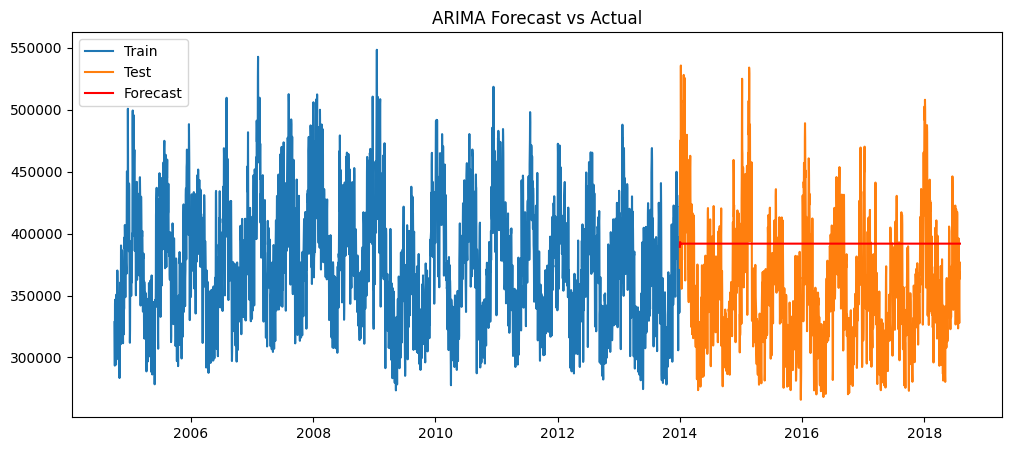

In [28]:
plt.figure(figsize=(12,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()

Forecast dengan Sarima Mingguan

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima7 = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
results_sarima7 = model_sarima7.fit()
forecast_sarima7 = results_sarima7.forecast(len(test))

In [37]:
rmse_sarima7 = sqrt(mean_squared_error(test, forecast_sarima7))
perc_rmse_sarima7 = (rmse_sarima7 / test.mean().values[0]) * 100
print(f"% RMSE: {perc_rmse_sarima7:.2f}%")
print(f"RMSE: {rmse_sarima7:.2f}")

% RMSE: 40.23%
RMSE: 143734.18


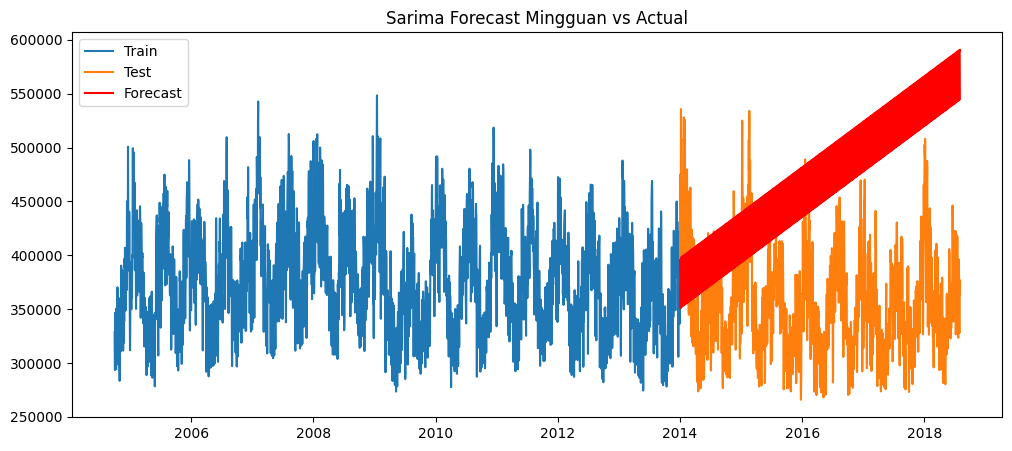

In [40]:
plt.figure(figsize=(12,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast_sarima7, label='Forecast', color='red')
plt.legend()
plt.title('Sarima Forecast Mingguan vs Actual')
plt.show()

Forecast dengan Sarima Bulanan

In [38]:
model_sarima12 = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
results_sarima12 = model_sarima12.fit()
forecast_sarima12 = results_sarima12.forecast(len(test))

In [39]:
rmse_sarima12 = sqrt(mean_squared_error(test, forecast_sarima12))
perc_rmse_sarima12 = (rmse_sarima12 / test.mean().values[0]) * 100
print(f"% RMSE: {perc_rmse_sarima12:.2f}%")
print(f"RMSE: {rmse_sarima12:.2f}")

% RMSE: 25.29%
RMSE: 90337.20


In [42]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_ES = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365)
fit_ES = model_ES.fit()
forecast_ES = fit_ES.forecast(len(test))


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [43]:
rmse_ES = sqrt(mean_squared_error(test, forecast_ES))
perc_rmse_ES = (rmse_ES / test.mean().values[0]) * 100
print(f"% RMSE: {perc_rmse_ES:.2f}%")
print(f"RMSE: {rmse_ES:.2f}")

% RMSE: 21.23%
RMSE: 75851.36


In [166]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_ES = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=180)
fit_ES = model_ES.fit()
forecast_ES = fit_ES.forecast(len(test))


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [167]:
rmse_ES = sqrt(mean_squared_error(test, forecast_ES))
perc_rmse_ES = (rmse_ES / test.mean().values[0]) * 100
print(f"% RMSE: {perc_rmse_ES:.2f}%")
print(f"RMSE: {rmse_ES:.2f}")

% RMSE: 20.33%
RMSE: 72636.48


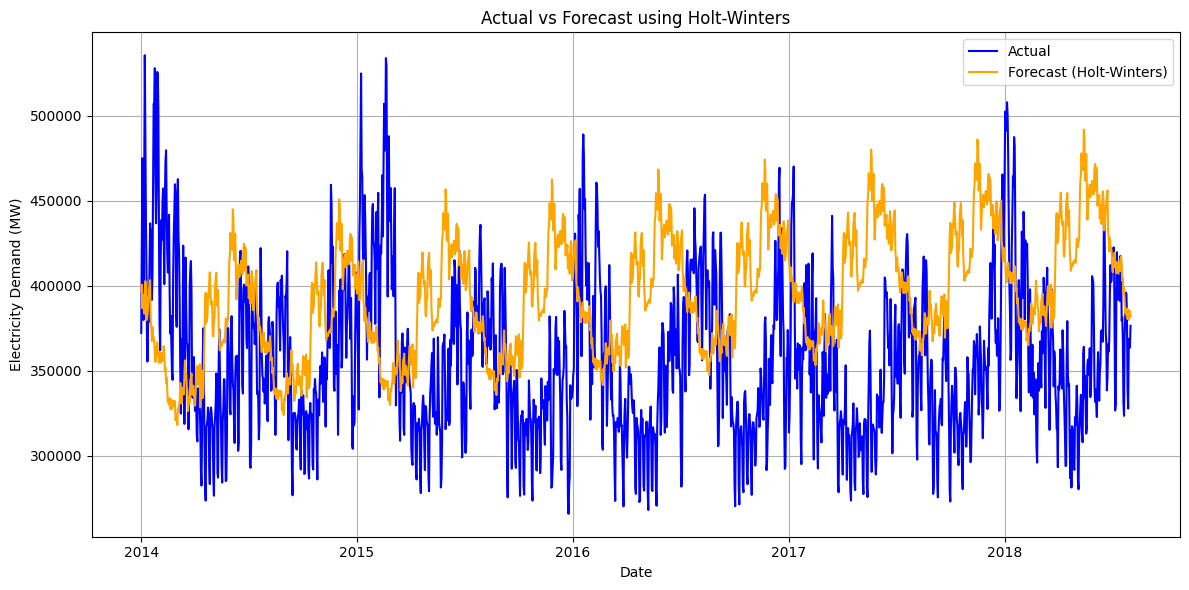

In [169]:
import matplotlib.pyplot as plt

# Pastikan indeks prediksi sama dengan test
forecast_ES.index = test.index

plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(forecast_ES.index, forecast_ES, label='Forecast (Holt-Winters)', color='orange')

plt.title('Actual vs Forecast using Holt-Winters')
plt.xlabel('Date')
plt.ylabel('Electricity Demand (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Facebook Prophte

Kuat untuk dataset dengan tren + musiman. Cocok untuk data harian

In [46]:
from prophet import Prophet

df_prophet = train.reset_index().rename(columns={'Datetime': 'ds', 'AEP_MW': 'y'})
model_prophet = Prophet()
model_prophet.fit(df_prophet)

future_prophet = model_prophet.make_future_dataframe(periods=len(test))
forecast_prophet = model_prophet.predict(future_prophet)
y_pred = forecast_prophet[['ds', 'yhat']].set_index('ds').loc[test.index, 'yhat']

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa1yvx8/asqoij44.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnsa1yvx8/whbmtm6q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16056', 'data', 'file=/tmp/tmpnsa1yvx8/asqoij44.json', 'init=/tmp/tmpnsa1yvx8/whbmtm6q.json', 'output', 'file=/tmp/tmpnsa1yvx8/prophet_modelwtx08gx7/prophet_model-20250619072823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:28:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:28:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [47]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_prophet = sqrt(mean_squared_error(test, y_pred))
perc_rmse_prophet = (rmse_prophet / test.mean().values[0]) * 100

print(f"RMSE: {rmse_prophet:.2f}")
print(f"% RMSE: {perc_rmse_prophet:.2f}%")


RMSE: 34681.86
% RMSE: 9.71%


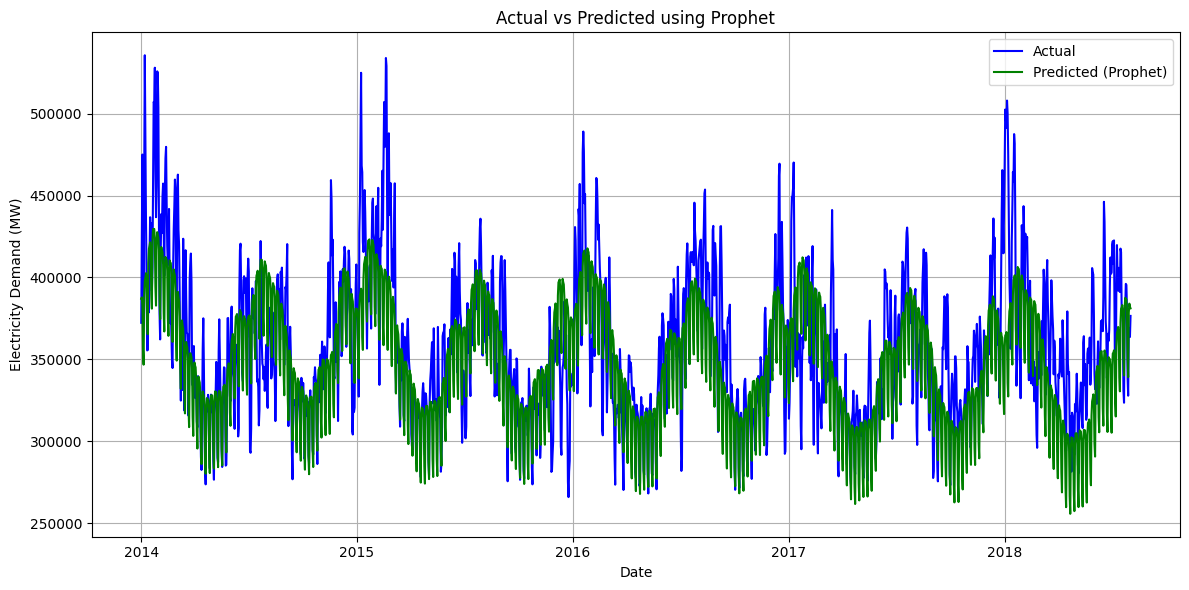

In [170]:
import matplotlib.pyplot as plt

# Pastikan prediksi Prophet memiliki index yang sama dengan test
y_pred = forecast_prophet[['ds', 'yhat']].set_index('ds').loc[test.index, 'yhat']

# Plot perbandingan data aktual dan prediksi
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(y_pred.index, y_pred, label='Predicted (Prophet)', color='green')
plt.title('Actual vs Predicted using Prophet')
plt.xlabel('Date')
plt.ylabel('Electricity Demand (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Random Forest

In [52]:
df = AEPdaily.copy()
df['lag_1'] = df['AEP_MW'].shift(1)
df['lag_2'] = df['AEP_MW'].shift(2)
df['lag_7'] = df['AEP_MW'].shift(7)  # 1 minggu
df['lag_30'] = df['AEP_MW'].shift(30)  # 1 bulan
df = df.reset_index()  # Sekarang 'Datetime' kembali menjadi kolom
df

,Datetime,AEP_MW,lag_1,lag_2,lag_7,lag_30
0,2004-10-01,328544.0,NaN,NaN,NaN,NaN
1,2004-10-02,311997.0,328544.0,NaN,NaN,NaN
2,2004-10-03,293450.0,311997.0,328544.0,NaN,NaN
3,2004-10-04,343417.0,293450.0,311997.0,NaN,NaN
4,2004-10-05,346553.0,343417.0,293450.0,NaN,NaN
...,...,...,...,...,...,...
5049,2018-07-29,327792.0,338714.0,379599.0,323504.0,412192.0
5050,2018-07-30,368834.0,327792.0,338714.0,369842.0,402247.0
5051,2018-07-31,364327.0,368834.0,327792.0,381373.0,403171.0
5052,2018-08-01,363628.0,364327.0,368834.0,396080.0,420069.0


In [53]:
df['dayofweek'] = df['Datetime'].dt.dayofweek
df['month'] = df['Datetime'].dt.month

In [54]:
def create_time_features(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    return df

In [55]:
from sklearn.ensemble import RandomForestRegressor

# Tambahkan fitur waktu
train_feat = create_time_features(train)
test_feat = create_time_features(test)

# Pisahkan X dan y
X_train = train_feat.drop(columns=['AEP_MW'])
y_train = train_feat['AEP_MW']
X_test = test_feat.drop(columns=['AEP_MW'])
y_test = test_feat['AEP_MW']


In [56]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
forecast_rf = model_rf.predict(X_test)

In [57]:
rmse_rf = sqrt(mean_squared_error(y_test, forecast_rf))
perc_rmse_rf = (rmse_rf / y_test.mean()) * 100

print(f"RMSE: {rmse_rf:.2f}")
print(f"% RMSE: {perc_rmse_rf:.2f}%")

RMSE: 37693.84
% RMSE: 10.55%


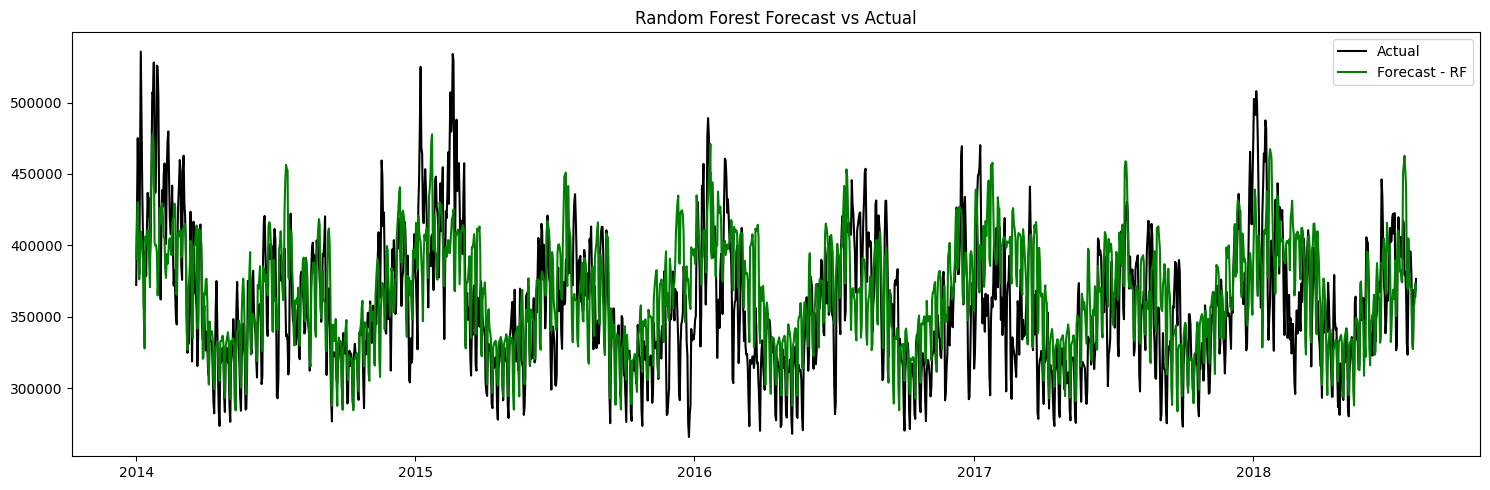

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', color='black')
plt.plot(y_test.index, forecast_rf, label='Forecast - RF', color='green')
plt.title("Random Forest Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()


XGBoost

In [60]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=100, random_state=42)
model_xgb.fit(X_train, y_train)

forecast_xgb = model_xgb.predict(X_test)

In [62]:
rmse_XGB = sqrt(mean_squared_error(y_test, forecast_xgb))
perc_rmse_XGB = (rmse_XGB / y_test.mean()) * 100

print(f"RMSE: {rmse_XGB:.2f}")
print(f"% RMSE: {perc_rmse_XGB:.2f}%")

RMSE: 38528.70
% RMSE: 10.79%


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', color='black')
plt.plot(y_test.index, forecast_rf, label='Forecast - RF', color='green')
plt.title("Random Forest Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()

Hybrid LSTM-Random Forest

In [63]:
def create_time_features2(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    return df

In [65]:
import numpy as np

def create_lstm_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        seq_x = series[i:i+window_size]
        seq_y = series[i+window_size]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [66]:
window_size = 30  # kamu bisa ubah ke 60 misalnya

# Pastikan data inputnya hanya series nilai
series = train['AEP_MW'].values
X_lstm, y_lstm = create_lstm_dataset(series, window_size)

# Ubah shape jadi [samples, timesteps, features]
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))


In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# reshape X to be [samples, time steps, features]
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

model_hybrid = Sequential()
model_hybrid.add(LSTM(50, activation='relu', input_shape=(X_lstm.shape[1], 1)))
model_hybrid.add(Dense(1))
model_hybrid.compile(optimizer='adam', loss='mse')
model_hybrid.fit(X_lstm, y_lstm, epochs=20, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 77489135616.0000
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9631370240.0000
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 18302048256.0000
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 22412800000.0000
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 59505500160.0000
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 66838499328.0000
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 40112779264.0000
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 14256658432.0000
Epoch 9/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 16247371776.0000
Epoch 10/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 14537587712.0000
Epoch 11/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 5957897728.0000
Epoch 12/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 41489911808.0000
Epoch 13/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2

In [69]:
forecast_hybrid = model_hybrid.predict(X_test)

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


In [72]:
# Buat ulang X_lstm dan y_lstm dari full AEPdaily (agar sinkron saat hybrid)
full_series = AEPdaily['AEP_MW'].values
X_lstm_full, _ = create_lstm_dataset(full_series, window_size)
X_lstm_full = X_lstm_full.reshape((X_lstm_full.shape[0], X_lstm_full.shape[1], 1))

# Prediksi pakai model LSTM
lstm_preds = model_hybrid.predict(X_lstm_full)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [73]:
# Sinkronkan tanggalnya (hilangkan window_size pertama)
dates_for_rf = AEPdaily.index[window_size:]

# DataFrame fitur waktu
df_rf = AEPdaily.copy().iloc[window_size:]
df_rf = df_rf.assign(LSTM_pred = lstm_preds.flatten())

# Tambahkan fitur waktu
def create_time_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    return df

df_rf_feat = create_time_features(df_rf)


In [74]:
train_rf = df_rf_feat[df_rf_feat.index < '2014-01-01']
test_rf = df_rf_feat[df_rf_feat.index >= '2014-01-01']

X_train_rf = train_rf.drop(columns=['AEP_MW'])
y_train_rf = train_rf['AEP_MW']
X_test_rf = test_rf.drop(columns=['AEP_MW'])
y_test_rf = test_rf['AEP_MW']


In [75]:
model_rf_hybrid = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_hybrid.fit(X_train_rf, y_train_rf)

# Prediksi
y_pred_rf = model_rf_hybrid.predict(X_test_rf)

In [76]:
rmse_rf_hybrid = sqrt(mean_squared_error(y_test_rf, y_pred_rf))
perc_rmse_rf_hybrid = (rmse_rf_hybrid / y_test_rf.mean()) * 100

print(f"RMSE Hybrid: {rmse_rf_hybrid:.2f}")
print(f"% RMSE Hybrid: {perc_rmse_rf_hybrid:.2f}%")

RMSE Hybrid: 35199.18
% RMSE Hybrid: 9.85%


GRU (Gated Recurrent Unit)

In [77]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(AEPdaily.values)

# Buat windowing data
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

n_steps = 30  # 30 hari sebelumnya sebagai input
X, y = create_sequences(scaled_data, n_steps)

# Split train-test berdasarkan indeks (ikut cara kamu sebelumnya)
split_idx = AEPdaily.index.get_loc('2014-01-01') - n_steps
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

modelgru = Sequential()
modelgru.add(GRU(64, activation='tanh', input_shape=(n_steps, 1)))
modelgru.add(Dense(1))
modelgru.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history = modelgru.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0506 - val_loss: 0.0138
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0122 - val_loss: 0.0107
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0105 - val_loss: 0.0098
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0096 - val_loss: 0.0087
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0089 - val_loss: 0.0082
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0080 - val_loss: 0.0068
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0071 - val_loss: 0.0068
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0069 - val_loss: 0.0063
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 12/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0064 - val_l

In [80]:
# Prediksi dan inverse scaling
y_pred_scaled = modelgru.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_orig = scaler.inverse_transform(y_test)

# Hitung RMSE
rmse_gru = sqrt(mean_squared_error(y_test_orig, y_pred))
perc_rmse_gru = (rmse_gru / np.mean(y_test_orig)) * 100

print(f"GRU RMSE     : {rmse_gru:.2f}")
print(f"GRU % RMSE   : {perc_rmse_gru:.2f}%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
GRU RMSE     : 18935.57
GRU % RMSE   : 5.30%


Metode Gru dengan K Fold

In [81]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

# Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(AEPdaily.values)

# Buat window sequence
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

n_steps = 30
X_all, y_all = create_sequences(scaled_data, n_steps)


In [83]:
kfold = KFold(n_splits=5, shuffle=False)  # jangan shuffle untuk time series
rmse_list = []

for fold, (train_idx, test_idx) in enumerate(kfold.split(X_all)):
    print(f"\nFold {fold+1}")

    X_train, X_val = X_all[train_idx], X_all[test_idx]
    y_train, y_val = y_all[train_idx], y_all[test_idx]

    modelgru2 = Sequential()
    modelgru2.add(GRU(64, activation='tanh', input_shape=(n_steps, 1))) #Coba relu
    modelgru2.add(Dense(1))
    modelgru2.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(patience=10, restore_best_weights=True)

    modelgru2.fit(X_train, y_train,
              epochs=50,
              batch_size=32,
              validation_data=(X_val, y_val),
              callbacks=[early_stop],
              verbose=0)

    y_val_pred_scaled = modelgru2.predict(X_val)
    y_val_pred = scaler.inverse_transform(y_val_pred_scaled)
    y_val_orig = scaler.inverse_transform(y_val)

    rmsegru2 = sqrt(mean_squared_error(y_val_orig, y_val_pred))
    print(f"RMSE Fold {fold+1}: {rmsegru2:.2f}")
    rmse_list.append(rmsegru2)



Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE Fold 1: 17403.37

Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
RMSE Fold 2: 17918.24

Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
RMSE Fold 3: 17777.65

Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
RMSE Fold 4: 18317.10

Fold 5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
RMSE Fold 5: 17982.64


In [87]:
RMSE_Mean = np.mean(rmse_list)
print(f"RMSE Mean: {RMSE_Mean:.2f}")

RMSE Mean: 17918.36


In [90]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(AEPdaily.values)

# Buat windowing data
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

n_steps = 30  # 30 hari sebelumnya sebagai input
X, y = create_sequences(scaled_data, n_steps)

# Split train-test berdasarkan indeks (ikut cara kamu sebelumnya)
split_idx = AEPdaily.index.get_loc('2014-01-01') - n_steps
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0414 - val_loss: 0.0132
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0126 - val_loss: 0.0114
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0108 - val_loss: 0.0089
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0085 - val_loss: 0.0080
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0073 - val_loss: 0.0063
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0068 - val_loss: 0.0062
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0066 - val_loss: 0.0072
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0061 - val_loss: 0.0054
Epoch 12/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0

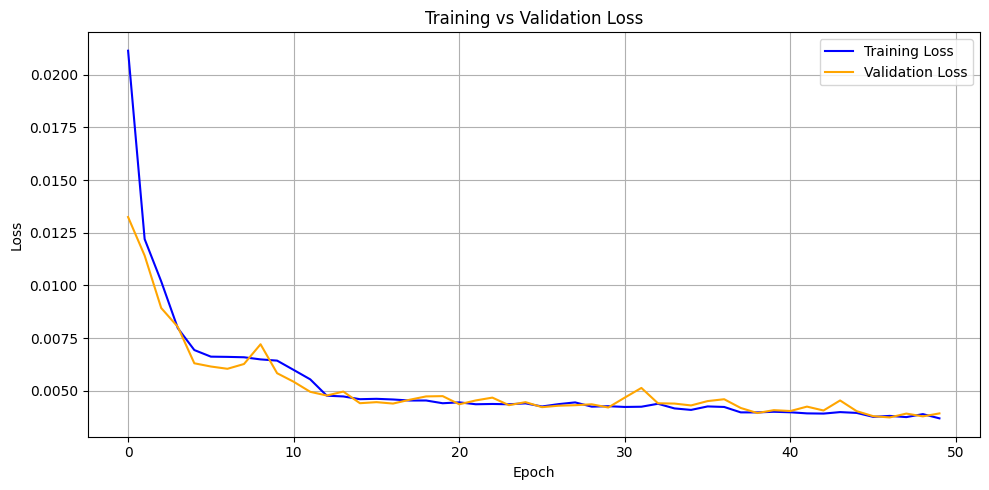

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


modelgru3 = Sequential()
modelgru3.add(GRU(32, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))
modelgru3.add(GRU(64, activation='tanh'))
modelgru3.add(Dense(1))
modelgru3.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history = modelgru3.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [93]:
# Prediksi dan inverse scaling
y_pred_scaled = modelgru3.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_orig = scaler.inverse_transform(y_test)

# Hitung RMSE
rmse_gru3 = sqrt(mean_squared_error(y_test_orig, y_pred))
perc_rmse_gru3 = (rmse_gru3 / np.mean(y_test_orig)) * 100

print(f"GRU RMSE     : {rmse_gru3:.2f}")
print(f"GRU % RMSE   : {perc_rmse_gru3:.2f}%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
GRU RMSE     : 18605.64
GRU % RMSE   : 5.21%


In [95]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input
from keras.optimizers import Adam

modelgru4 = Sequential()
modelgru4.add(Input(shape=(90, 1)))  # Ganti n_steps sesuai window kamu
modelgru4.add(GRU(64, activation='tanh', return_sequences=True))
modelgru4.add(Dropout(0.2))
modelgru4.add(GRU(32, activation='tanh'))
modelgru4.add(Dropout(0.2))
modelgru4.add(Dense(1))

modelgru4.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
modelgru4.summary()

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history2 = modelgru4.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_13 (GRU)                    │ (None, 90, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_14 (GRU)                    │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,305 (87.13 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 0.0473 - val_loss: 0.0132
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0160 - val_loss: 0.0117
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0140 - val_loss: 0.0109
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0118 - val_loss: 0.0089
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0107 - val_loss: 0.0073
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0098 - val_loss: 0.0067
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0094 - val_loss: 0.0064
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0087 - val_loss: 0.0065
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0085 - val_loss: 0.0063
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0084 - val_loss: 0.0065
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0080 - val_loss: 0.0064
Epoch 12/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.

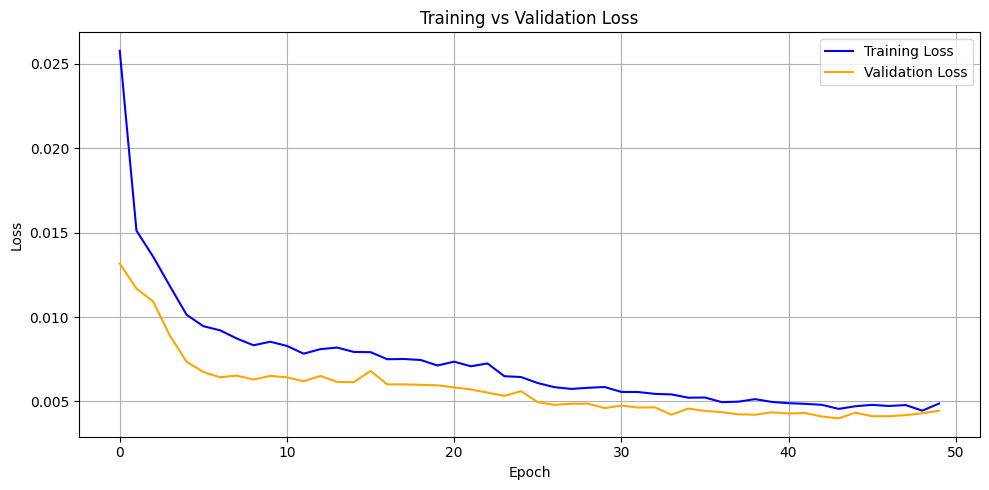

In [98]:
plt.figure(figsize=(10, 5))
plt.plot(history2.history['loss'], label='Training Loss', color='blue')
plt.plot(history2.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [99]:
# Prediksi dan inverse scaling
y_pred_scaled = modelgru4.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_orig = scaler.inverse_transform(y_test)

# Hitung RMSE
rmse_gru4 = sqrt(mean_squared_error(y_test_orig, y_pred))
perc_rmse_gru4 = (rmse_gru4 / np.mean(y_test_orig)) * 100

print(f"GRU RMSE     : {rmse_gru4:.2f}")
print(f"GRU % RMSE   : {perc_rmse_gru4:.2f}%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
GRU RMSE     : 19037.09
GRU % RMSE   : 5.33%


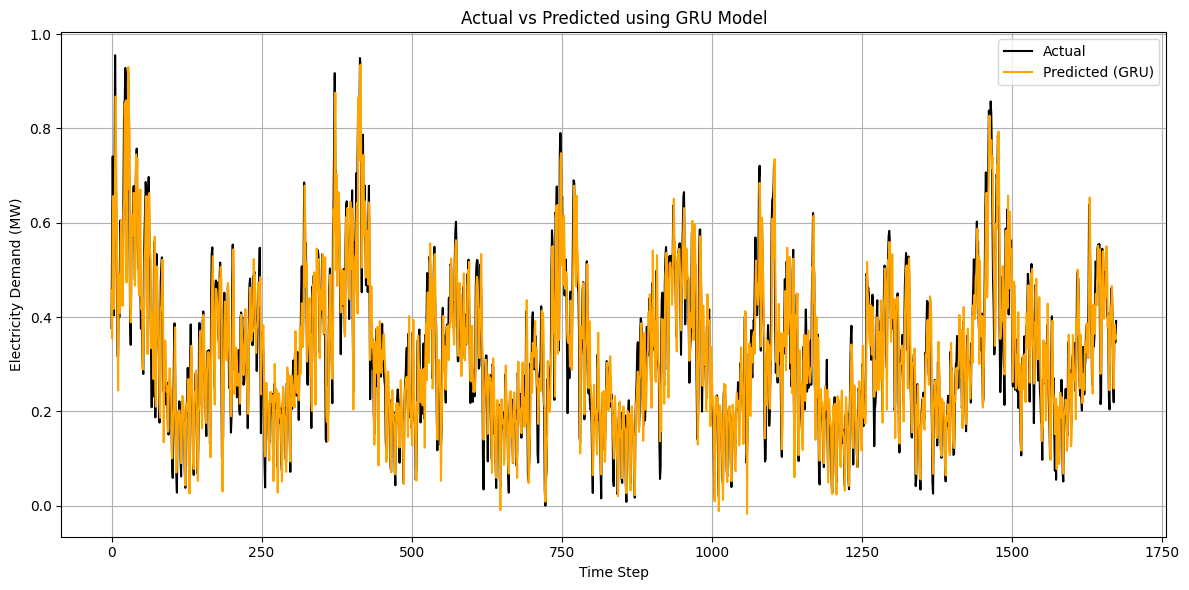

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', color='black')
plt.plot(gru_preds, label='Predicted (GRU)', color='orange')
plt.title('Actual vs Predicted using GRU Model')
plt.xlabel('Time Step')
plt.ylabel('Electricity Demand (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **MODEL TERBAIK**

In [108]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input
from keras.optimizers import Adam

modelgru5 = Sequential()
modelgru5.add(Input(shape=(30, 1)))  # Ganti n_steps sesuai window kamu
modelgru5.add(GRU(64, activation='tanh', return_sequences=True))
modelgru5.add(Dropout(0.2))
modelgru5.add(GRU(32, activation='tanh'))
modelgru5.add(Dropout(0.2))
modelgru5.add(Dense(1))

modelgru5.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
modelgru5.summary()

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history3 = modelgru5.fit(X_train, y_train,
                    epochs=50,
                    batch_size=16,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_17 (GRU)                    │ (None, 30, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_18 (GRU)                    │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,305 (87.13 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - loss: 0.0380 - val_loss: 0.0125
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0140 - val_loss: 0.0113
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0126 - val_loss: 0.0078
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0098 - val_loss: 0.0068
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0090 - val_loss: 0.0063
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0084 - val_loss: 0.0063
Epoch 7/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0082 - val_loss: 0.0062
Epoch 8/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0079 - val_loss: 0.0067
Epoch 9/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0081 - val_loss: 0.0061
Epoch 10/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0079 - val_loss: 0.0069
Epoch 11/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 0.0072 - val_loss: 0.0061
Epoch 12/50
168/168 ━━━━━━━━━━━━━━━━━━━

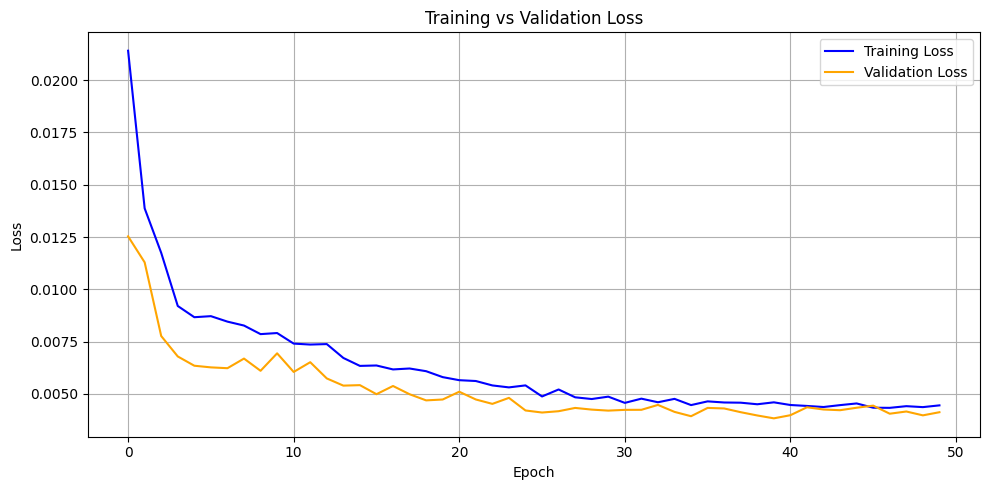

In [109]:
plt.figure(figsize=(10, 5))
plt.plot(history3.history['loss'], label='Training Loss', color='blue')
plt.plot(history3.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

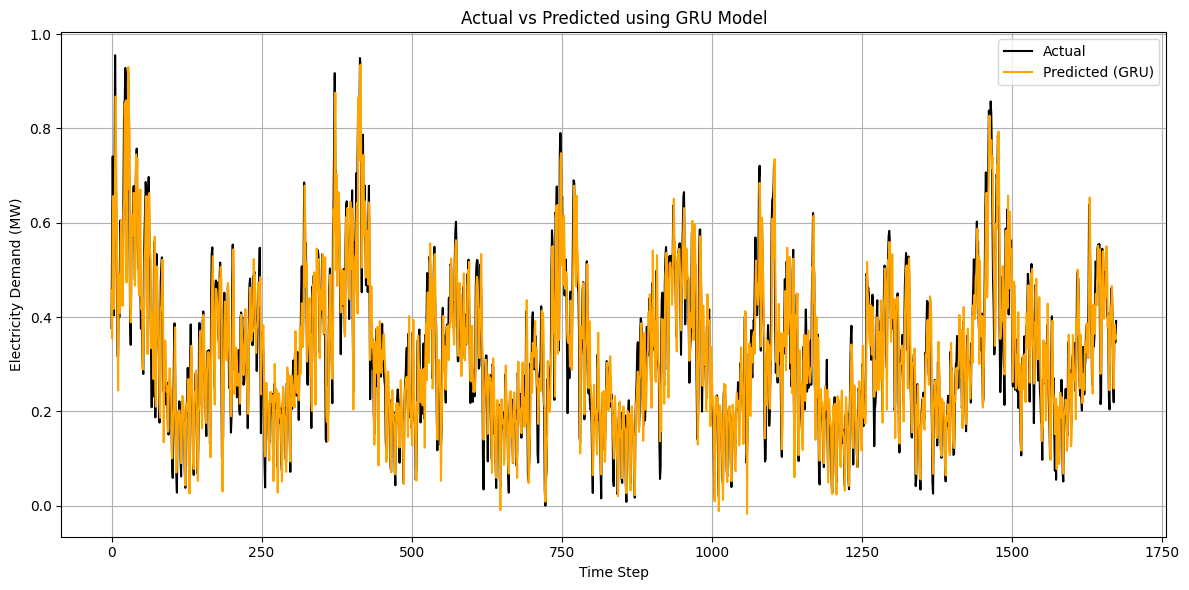

In [117]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', color='black')
plt.plot(gru_preds, label='Predicted (GRU)', color='orange')
plt.title('Actual vs Predicted using GRU Model')
plt.xlabel('Time Step')
plt.ylabel('Electricity Demand (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [110]:
# Prediksi dan inverse scaling
y_pred_scaled = modelgru5.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_orig = scaler.inverse_transform(y_test)

# Hitung RMSE
rmse_gru5 = sqrt(mean_squared_error(y_test_orig, y_pred))
perc_rmse_gru5 = (rmse_gru5 / np.mean(y_test_orig)) * 100

print(f"GRU RMSE     : {rmse_gru5:.2f}")
print(f"GRU % RMSE   : {perc_rmse_gru5:.2f}%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
GRU RMSE     : 18538.30
GRU % RMSE   : 5.19%


In [114]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input
from keras.optimizers import Adam

modelgru6 = Sequential()
modelgru6.add(Input(shape=(90, 1)))  # Ganti n_steps sesuai window kamu
modelgru6.add(GRU(128, activation='tanh', return_sequences=True))
modelgru6.add(Dropout(0.2))
modelgru6.add(GRU(64, activation='tanh', return_sequences=True))
modelgru6.add(Dropout(0.2))
modelgru6.add(GRU(32, activation='tanh'))
modelgru6.add(Dropout(0.2))
modelgru6.add(Dense(1))

modelgru6.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
modelgru6.summary()

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history4 = modelgru6.fit(X_train, y_train,
                    epochs=50,
                    batch_size=16,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_28 (GRU)                    │ (None, 90, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_29 (GRU)                    │ (None, 90, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_30 (GRU)                    │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,993 (378.88 KB)

 Trainable params: 96,993 (378.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - loss: 0.0302 - val_loss: 0.0135
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - loss: 0.0159 - val_loss: 0.0097
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - loss: 0.0104 - val_loss: 0.0068
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - loss: 0.0093 - val_loss: 0.0064
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - loss: 0.0087 - val_loss: 0.0075
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 0.0086 - val_loss: 0.0091
Epoch 7/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 0.0087 - val_loss: 0.0064
Epoch 8/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 0.0076 - val_loss: 0.0061
Epoch 9/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0075 - val_loss: 0.0060
Epoch 10/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 0.0065 - val_loss: 0.0068
Epoch 11/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.0072 - val_loss: 0.0057
Epoch 12/50
168/168 ━━━━━━━━━━

In [116]:
# Prediksi dan inverse scaling
y_pred_scaled = modelgru5.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_orig = scaler.inverse_transform(y_test)

# Hitung RMSE
rmse_gru5 = sqrt(mean_squared_error(y_test_orig, y_pred))
perc_rmse_gru5 = (rmse_gru5 / np.mean(y_test_orig)) * 100

print(f"GRU RMSE     : {rmse_gru5:.2f}")
print(f"GRU % RMSE   : {perc_rmse_gru5:.2f}%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
GRU RMSE     : 18538.30
GRU % RMSE   : 5.19%


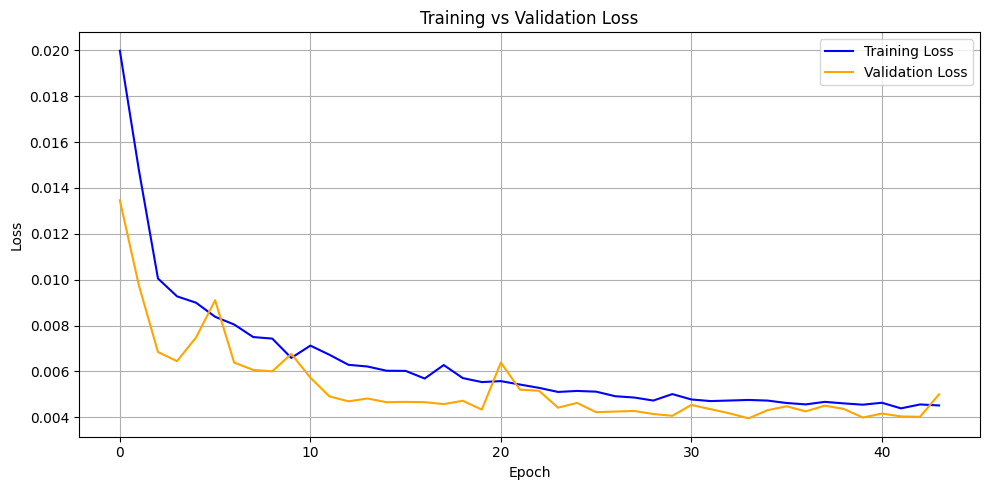

In [115]:
plt.figure(figsize=(10, 5))
plt.plot(history4.history['loss'], label='Training Loss', color='blue')
plt.plot(history4.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [119]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input
from keras.optimizers import Adam
from keras.optimizers import RMSprop

modelgru7 = Sequential()
modelgru7.add(Input(shape=(30, 1)))  # Ganti n_steps sesuai window kamu
modelgru7.add(GRU(64, activation='tanh', return_sequences=True))
modelgru7.add(Dropout(0.2))
modelgru7.add(GRU(32, activation='tanh'))
modelgru7.add(Dropout(0.2))
modelgru7.add(Dense(1))

modelgru7.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse')
modelgru7.summary()

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history7= modelgru5.fit(X_train, y_train,
                    epochs=50,
                    batch_size=16,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_33 (GRU)                    │ (None, 30, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_34 (GRU)                    │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,305 (87.13 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 7/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 8/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 9/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 10/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0042 - val_loss: 0.0047
Epoch 11/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0040 - val_loss: 0.0043
Epoch 12/50
168/168 ━━━━━━━━━━━━━━━━━━

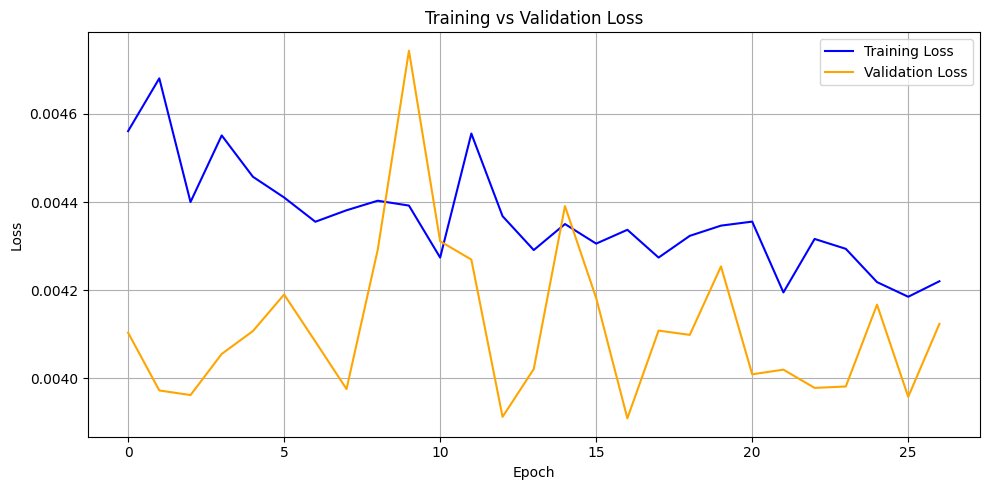

In [120]:
plt.figure(figsize=(10, 5))
plt.plot(history7.history['loss'], label='Training Loss', color='blue')
plt.plot(history7.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Model ini tidak saya jadikan best model karena walaupun memiliki hasil RMSE paling rendah, grafik antara training loss dan validation loss menggambarkan kemungkinan model overfitting.

In [121]:
# Prediksi dan inverse scaling
y_pred_scaled = modelgru5.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_orig = scaler.inverse_transform(y_test)

# Hitung RMSE
rmse_gru7 = sqrt(mean_squared_error(y_test_orig, y_pred))
perc_rmse_gru7 = (rmse_gru7 / np.mean(y_test_orig)) * 100

print(f"GRU RMSE     : {rmse_gru7:.2f}")
print(f"GRU % RMSE   : {perc_rmse_gru7:.2f}%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
GRU RMSE     : 18593.95
GRU % RMSE   : 5.20%


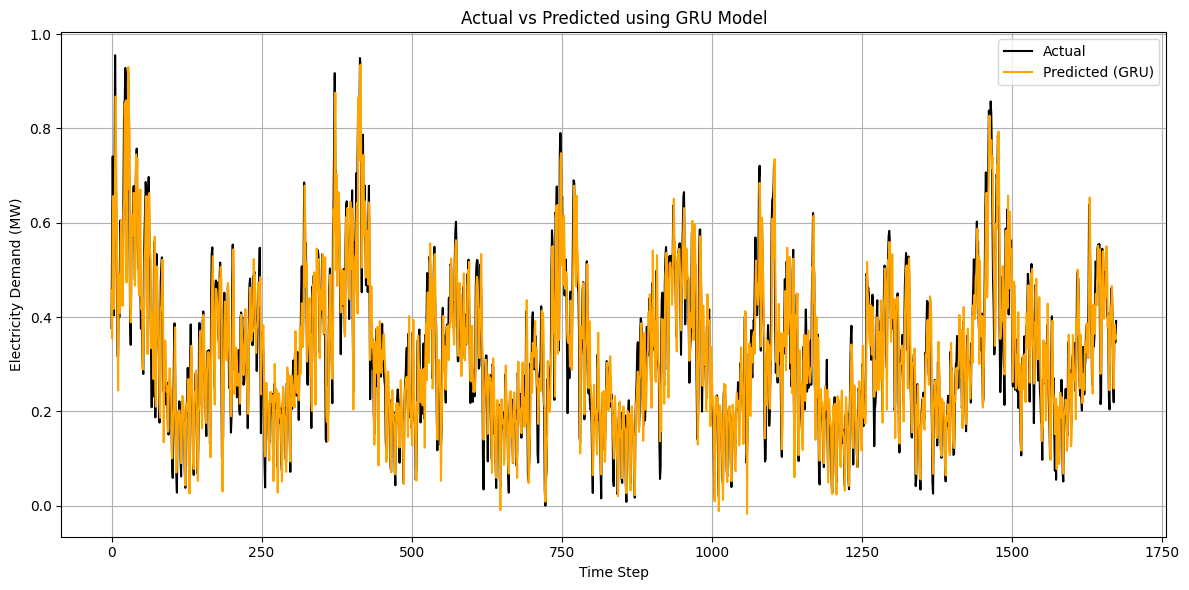

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', color='black')
plt.plot(gru_preds, label='Predicted (GRU)', color='orange')
plt.title('Actual vs Predicted using GRU Model')
plt.xlabel('Time Step')
plt.ylabel('Electricity Demand (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [131]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input
from keras.optimizers import Adam
from keras.optimizers import RMSprop,Adamax
from keras.activations import swish

modelgru7 = Sequential()
modelgru7.add(Input(shape=(90, 1)))  # Ganti n_steps sesuai window kamu
modelgru7.add(GRU(128, activation='relu', return_sequences=True))
modelgru7.add(Dropout(0.2))
modelgru7.add(GRU(64, activation='relu'))
modelgru7.add(Dense(1))

modelgru7.compile(optimizer=Adamax(learning_rate=0.001), loss='mse')
modelgru7.summary()

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history7= modelgru5.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_43 (GRU)                    │ (None, 90, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 90, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_44 (GRU)                    │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,617 (342.25 KB)

 Trainable params: 87,617 (342.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 10/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 11/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 12/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0

In [127]:
# Prediksi dan inverse scaling
y_pred_scaled = modelgru5.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_orig = scaler.inverse_transform(y_test)

# Hitung RMSE
rmse_gru7 = sqrt(mean_squared_error(y_test_orig, y_pred))
perc_rmse_gru7 = (rmse_gru7 / np.mean(y_test_orig)) * 100

print(f"GRU RMSE     : {rmse_gru7:.2f}")
print(f"GRU % RMSE   : {perc_rmse_gru7:.2f}%")

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
GRU RMSE     : 18291.54
GRU % RMSE   : 5.12%


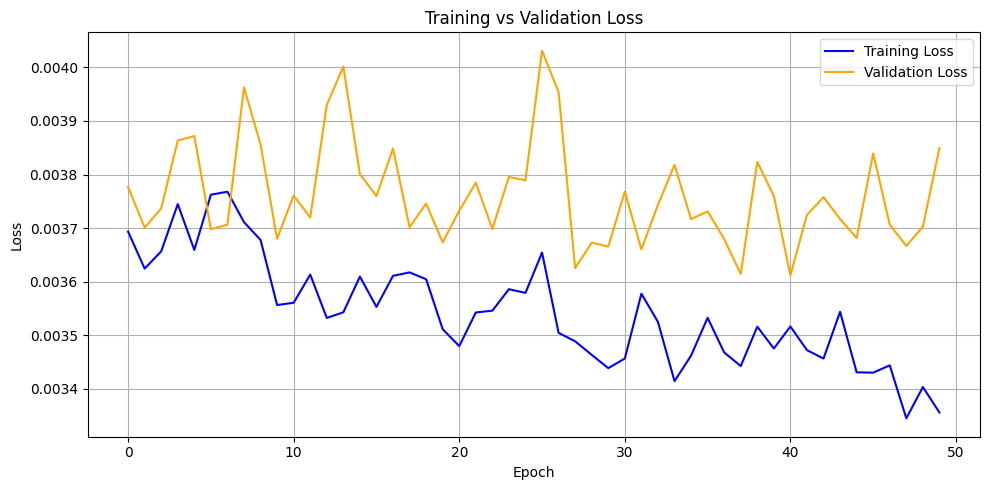

In [146]:
plt.figure(figsize=(10, 5))
plt.plot(history7.history['loss'], label='Training Loss', color='blue')
plt.plot(history7.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()